# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
# !pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [ ]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [ ]:
cap = cv2.VideoCapture("rtsp://147.232.24.197/live.sdp")
# cap = cv2.VideoCapture(0)
imgnum = 0
while (imgnum == number_images):
    i = i + 1
    ret, frame = cap.read()
    if imgnum % 12 == 0:
        print('Collecting image {}'.format(imgnum))
        imgnum = imgnum + 1
        imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)
        cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [ ]:
# !labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [ ]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os

### 2.2 Limit GPU Memory Growth

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [ ]:
images = tf.data.Dataset.list_files('data\\datasets\\images\\webcam_2\\*.jpg')
images.as_numpy_iterator().next()

In [ ]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)
images.as_numpy_iterator().next()
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

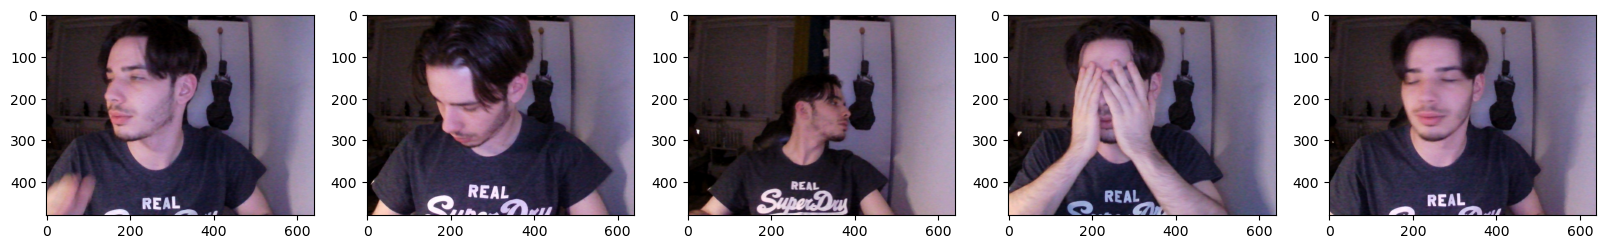

In [ ]:
image_generator = images.batch(5).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
30*.7 # 21 to train

21.0

In [ ]:
30*.15 # 5 and 4 to test and val

4.5

### 3.2 Move the Matching Labels

In [ ]:
camera = 'webcam' # or seccam
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', camera, folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', camera, 'labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data', camera, folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [ ]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [ ]:
cam = 'webcam' # or seccam
img = cv2.imread(os.path.join('data', cam, 'train', 'images','f4c656f6-8335-11ee-af95-9cfeff47d2fa.jpg'))

with open(os.path.join('data', cam, 'train', 'labels', 'f4c656f6-8335-11ee-af95-9cfeff47d2fa.json'), 'r') as f:
    label = json.load(f)

label['shapes'][0]['points']

[[191.7777777777778, 35.111111111111114],
 [425.1111111111111, 258.6666666666667]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[191.7777777777778, 35.111111111111114, 425.1111111111111, 258.6666666666667]

In [ ]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.2996527777777778, 0.07314814814814816, 0.664236111111111, 0.538888888888889]

### 4.4 Apply Augmentations and View Results

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented['bboxes'][0][2:]

(0.7582716049382716, 0.5525925925925926)

In [ ]:
augmented['bboxes']

[(0.3928395061728396,
  0.058024691358024696,
  0.911358024691358,
  0.5548148148148149)]

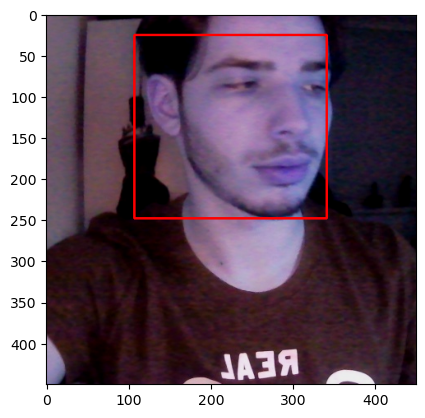

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [ ]:
cam = 'webcam' # or 'seccam' 
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', cam, partition, 'images')):
        img = cv2.imread(os.path.join('data', cam, partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', cam, partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480])) # set the size 640 to 480

        try: 
            for x in range(60): # create 60 augmented images for every single base image
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('datasets\augmented', cam, partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('datasets\augmented', cam, partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

y_max is less than or equal to y_min for bbox [0.2913896276595745, 0.5476507092198583, 0.6620678191489362, 0.05119680851063835, 'face'].
y_max is less than or equal to y_min for bbox [0.19498005319148934, 0.586436170212766, 0.5249335106382979, 0.0955230496453901, 'face'].
y_max is less than or equal to y_min for bbox [0.28972739361702127, 0.6529255319148937, 0.6645611702127658, 0.19082446808510642, 'face'].
y_max is less than or equal to y_min for bbox [0.2872340425531915, 0.4468085106382979, 0.6628989361702128, 0.0013297872340426037, 'face'].
y_max is less than or equal to y_min for bbox [0.2830784574468085, 0.3747783687943263, 0.6188497340425532, 0.010195035460992957, 'face'].
y_max is less than or equal to y_min for bbox [0.28058510638297873, 0.4080230496453901, 0.5997340425531915, 0.005762411347517781, 'face'].
y_max is less than or equal to y_min for bbox [0.2323803191489362, 0.5941932624113476, 0.4675864361702128, 0.22406914893617025, 'face'].
y_max is less than or equal to y_min

### 5.2 Load Augmented Images to Tensorflow Dataset

In [ ]:
cam = 'webcam' # or seccam
train_images = tf.data.Dataset.list_files('datasets\augmented\\{cam}\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files('datasets\augmented\\{cam}\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('datasets\augmented\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [ ]:
train_labels = tf.data.Dataset.list_files('datasets\augmented\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files('datasets\augmented\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('datasets\augmented\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

### 7.2 Create Final Datasets (Images/Labels)

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

NameError: name 'train_images' is not defined

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

### 7.3 View Images and Annotations

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)